# Predicting Newsletter Subscription Based on Player Behaviour
## Introduction
**Background**: UBC's Pacific Laboratory for Artificial Intelligence (PLAI) research group runs a Minecraft server called PLAICraft to study player behaviour. They want to know what player traits and behaviours are linked to subscribing to a newsletter.

**Research Question**: Can we predict whether a player will subscribe to a newsletter based on their demographics and gameplay behaviour?

In [96]:
# Load libraries
library(tidyverse)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.



## Data Loading

In [97]:
# Load data
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Data Wrangling

In [98]:
# Compute session duration
sessions <- sessions |>
    mutate(duration_minutes = as.numeric(as_datetime(original_end_time / 1000) - as_datetime(original_start_time / 1000)) / 60)

# Summary table for player data
session_summary <- sessions |>
    group_by(hashedEmail) |>
    summarize(total_sessions = n(),
             total_minutes_played = sum(duration_minutes, na.rm = TRUE),
             avg_session_duration = mean(duration_minutes, na.rm = TRUE))

# Merge with player data
players_merge <- players |>
    left_join(session_summary, by = "hashedEmail") |>
    mutate(
        total_sessions = replace_na(total_sessions, 0),
        total_minutes_played = replace_na(total_minutes_played, 0),
        avg_session_duration = replace_na(avg_session_duration, 0),
        total_hours_played = total_minutes_played / 60
    )

## Data Visualization

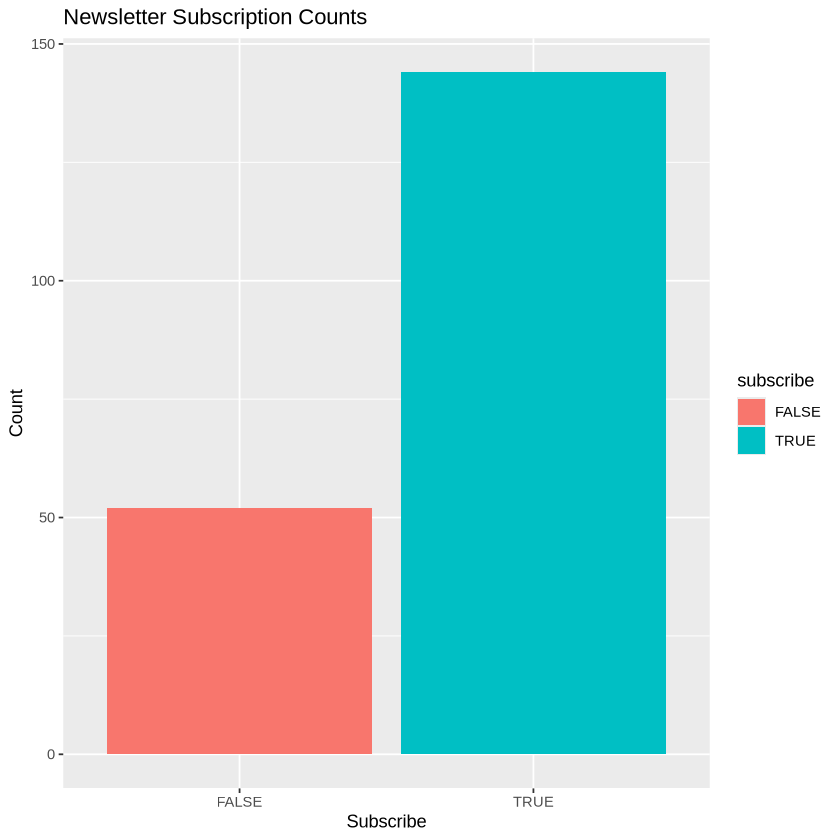

In [99]:
# Newsletter Subscription Counts
sub_count <- players_merge |>
    ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscribe", y = "Count", title = "Newsletter Subscription Counts")
sub_count

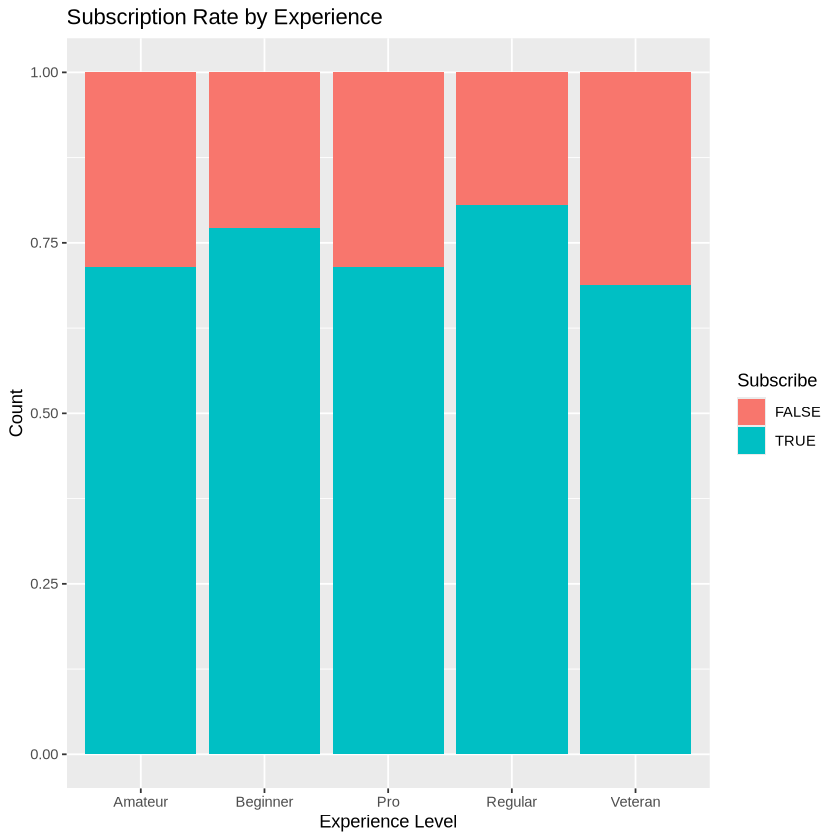

In [100]:
# Subscription by experience
sub_exp <- players_merge |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Experience Level", y = "Count", title = "Subscription Rate by Experience", fill = "Subscribe")
sub_exp

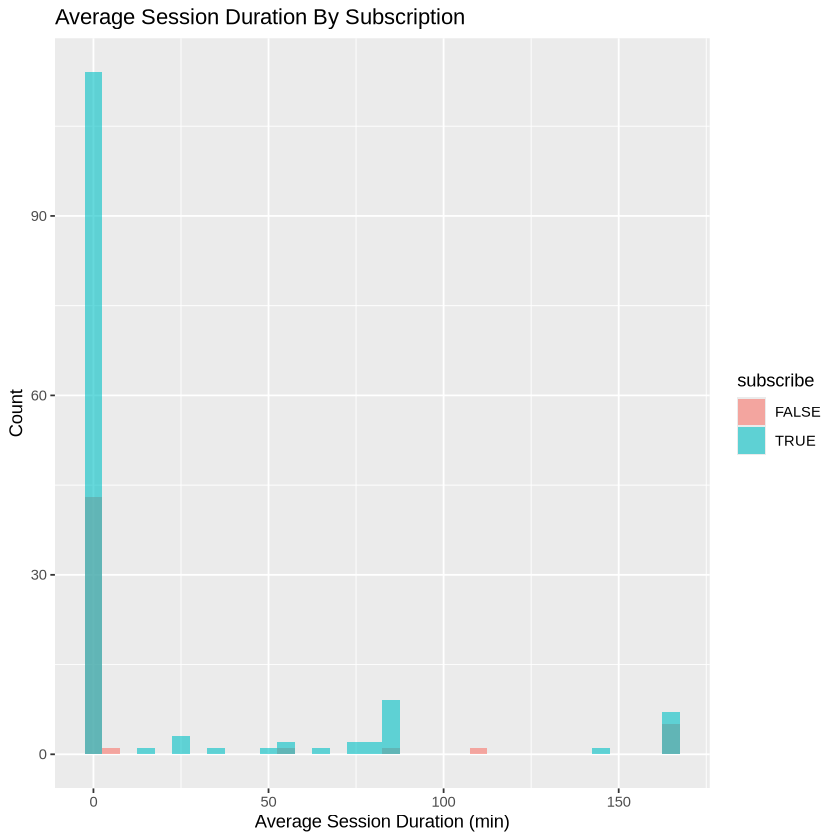

In [101]:
# Average session duration by Subscription
avg_sesh_sub <- players_merge |>
    ggplot(aes(x = avg_session_duration, fill = subscribe)) + 
    geom_histogram(binwidth = 5, position = "identity", alpha = 0.6) +
    labs(x = "Average Session Duration (min)", y = "Count", title = "Average Session Duration By Subscription")
avg_sesh_sub

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


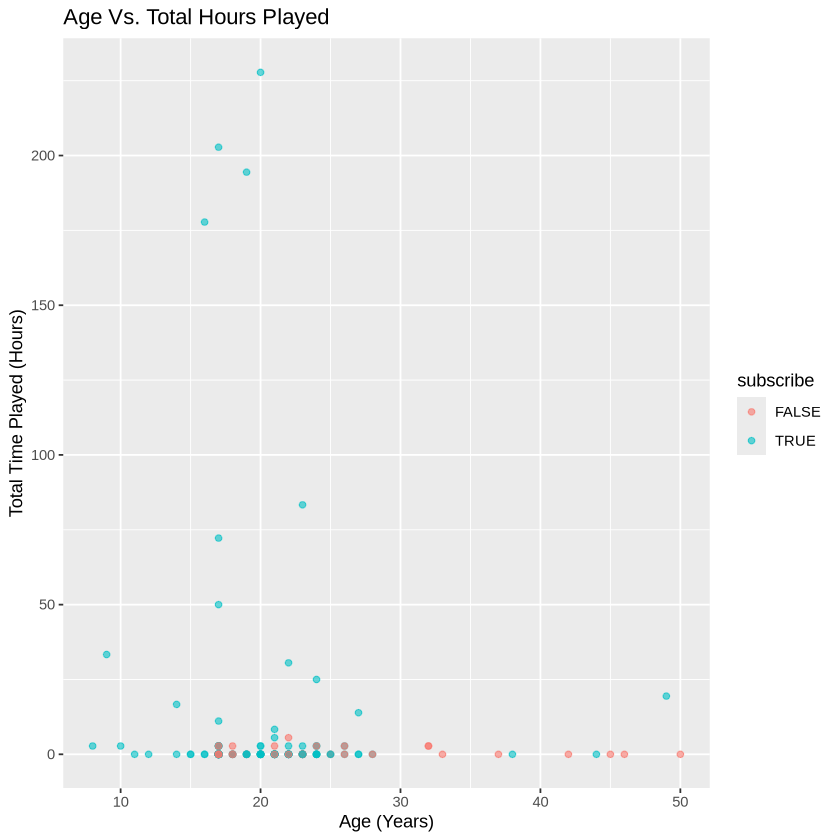

In [102]:
#Age vs. Total Hours Played
age_total_hr <- players_merge |>
    ggplot(aes(x = Age, y = total_hours_played, colour = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (Years)", y = "Total Time Played (Hours)", title = "Age Vs. Total Hours Played", Colour = "Subscribe")
age_total_hr

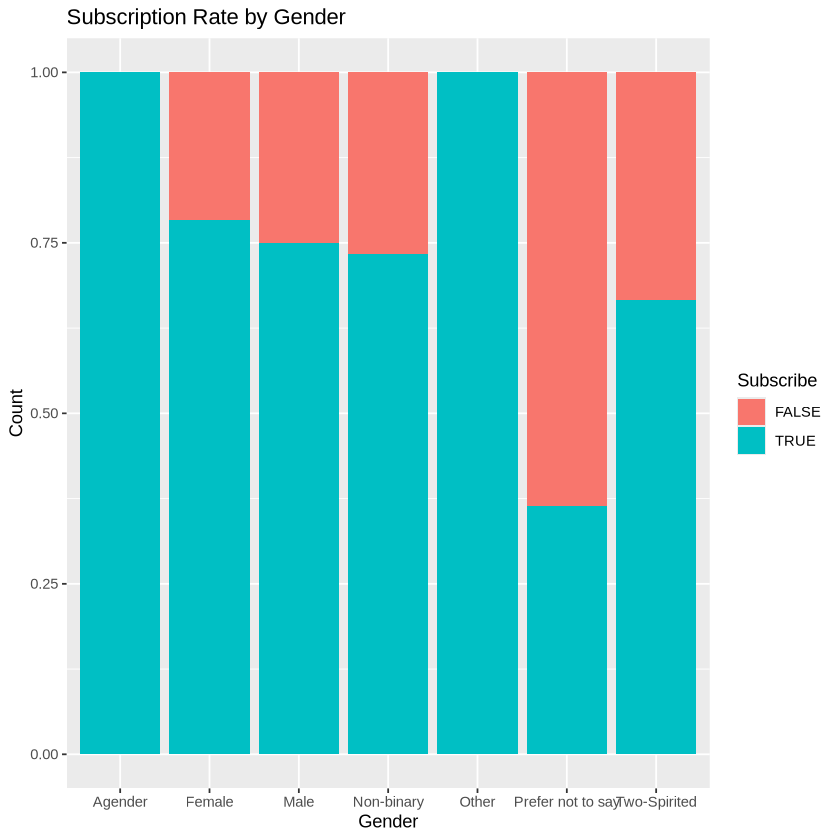

In [103]:
# Subscription by gender
sub_gen <- players_merge |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Gender", y = "Count", title = "Subscription Rate by Gender", fill = "Subscribe")
sub_gen

## Modeling

### Data Setup

In [116]:
# Ensure results are reproducible 
set.seed(1234)

# Convert the target variable to factor
players_merge <- players_merge |>
    mutate(subscribe = as_factor(subscribe))

#split data
players_merge <- players_merge |>
    drop_na()
split <- initial_split(players_merge, strata = subscribe)
data_train <- training(split)
data_test <- testing(split)

### Model

In [126]:
# Recipe using numeric features
recipe_subscribe <- recipe(subscribe ~ played_hours + Age + total_sessions + avg_session_duration, data = data_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

# KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#5-fold cross-validation
players_vfold <- vfold_cv(data_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

# Workflow
knn_results <- workflow() |>
    add_recipe(recipe_subscribe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

[1] 22

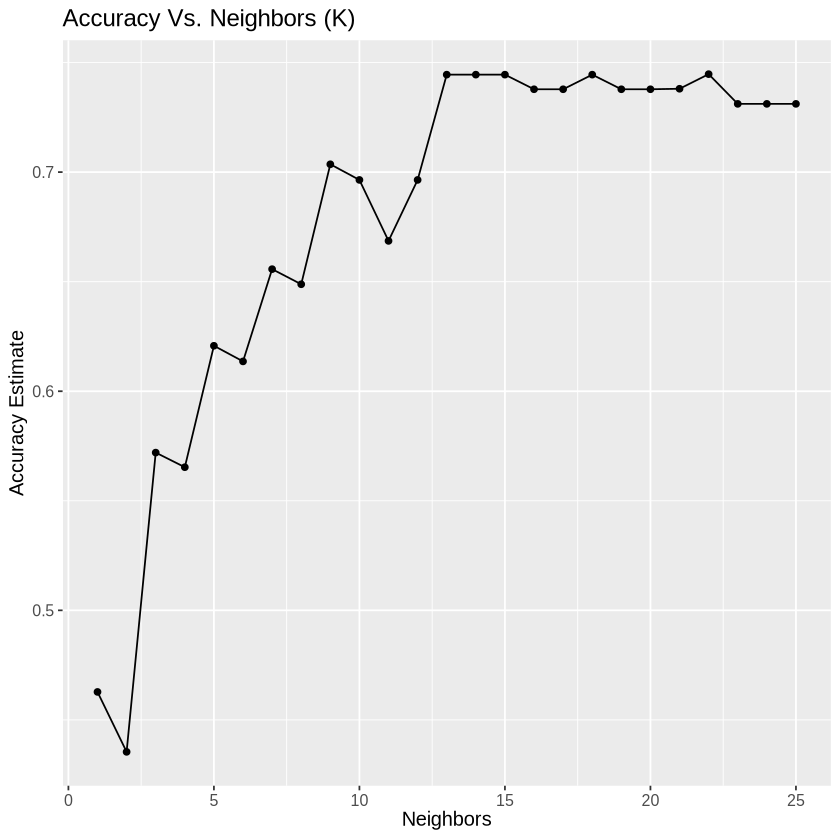

In [131]:
# Visualizing Accuracy Vs. K
accuracy_vs_k <- knn_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Vs. Neighbors (K)") +
  theme(text = element_text(size = 12))

#best K
best_k <- knn_results |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
    
best_k
accuracy_vs_k